<a href="https://colab.research.google.com/github/HeningWang/numpyro_adjective_modelling/blob/main/02_Posterior_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import modules and dependencies


In [1]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro
!git clone https://github.com/HeningWang/numpyro_adjective_modelling.git
!pip install siuba

from google.colab import drive
drive.mount('/content/drive')

import os

from IPython.display import set_matplotlib_formats
import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
numpyro.set_platform("gpu")

plt.style.use("bmh")
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

assert numpyro.__version__.startswith("0.12.1")

  Preparing metadata (setup.py) ... done
fatal: destination path 'numpyro_adjective_modelling' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
print(jax.__version__)
jax.devices()

0.4.13


[gpu(id=0)]

In [3]:
import sys
sys.path.append('/content/numpyro_adjective_modelling')

Some helper functions:

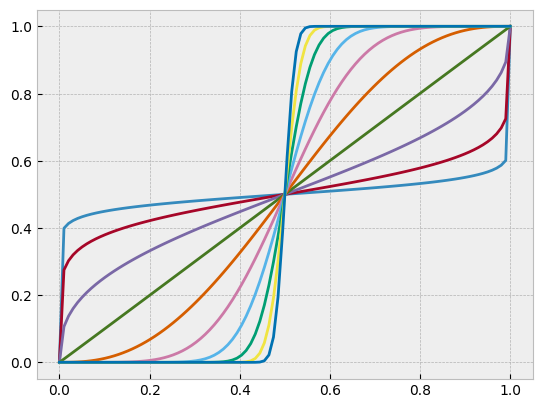

In [4]:
import numpy as np
from scipy.stats import norm

%matplotlib inline
from scipy.special import betainc
import numpy as np
import math
import matplotlib.pyplot as plt

x = np.linspace(0., 1., 100)
N = 10

for i in range(N):
    k = 0.5 * np.exp(i) / N
    plt.plot(x, betainc(k, k, x))

#plt.gca().set_xlim(0,1)
#plt.gca().set_ylim(0,1)
#plt.show()

def link_function_S(x, param=None):
  N = 10
  k = 0.5 * jnp.exp(param) / N
  return jax.scipy.stats.beta.cdf(x,k,k)



In [5]:
# Mutate the dataset to include the states of the objects
# ... states are independent variables for models

def extract_states(line):
    states = []
    for i in range(6):
      color = 1 if line[10 + i] == "blue" else 0
      form = 1 if line[16 + i] == "circle" else 0
      new_obj = (line[4 + i], color, form)
      states.append(new_obj)
    return jnp.array(states)


# Transform/rescale slider value from range 0 to 100 to 0 to 1
# ... in order to match predicted probability from models

def transformation_data(slider_value, link = None):
    if link == "identity":
      slider_value = jnp.clip(slider_value, 0, 100)
      transformed_prob = slider_value / 100
    elif link == "logit":
        transformed_prob = 1 / (1 + math.exp(-slider_value))
    return transformed_prob

def link_function(x, param = 1):
    return 1 / (1 + jnp.exp(param * -(x - 0.5)))

def compute_alpha_beta_concentration(mu, v):
    alpha = mu * v
    beta = (1 - mu) * v
    return alpha, beta

def Marginal(fn):
    return memoize(lambda *args: HashingMarginal(Search(fn).run(*args)))

def plot_dist(d, ax=None):
    support = d.enumerate_support()
    data = [d.log_prob(s).exp().item() for s in d.enumerate_support()]
    names = list(map(str, support))

    if ax is None:
        ax = plt.subplot(111)

    width = 0.3
    bins = [x-width/2 for x in range(1, len(data) + 1)]
    ax.bar(bins,data,width=width)
    ax.set_xticks(list(range(1, len(data) + 1)))
    ax.set_xticklabels(names, rotation=45, rotation_mode="anchor", ha="right")

def get_results(posterior):
    results = {}
    support = posterior.enumerate_support()
    data = [posterior.log_prob(s).exp().item() for s in posterior.enumerate_support()]
    results["support"] = support
    results["probs"] = data
    return results

def normalize(arr, axis=1):
    """
    Normalize arr along axis
    """
    return arr / arr.sum(axis, keepdims=True)

In [6]:
# Import dataset
dataset_url = "/content/numpyro_adjective_modelling/dataset/dataset_slider.csv"
df = pd.read_csv(dataset_url)

# subset data to only include combination dimension_color
df = df[df['combination'] == 'dimension_color']
df.reset_index(inplace=True, drop=True)

# Mutate the dataset to include the states of the objects
df_experiment = df.copy()
df_experiment["states"] = df_experiment.apply(lambda row: extract_states(row), axis=1)

df_experiment.prefer_first_1st = jnp.clip(df_experiment.prefer_first_1st.to_numpy(), 0, 100)
df_experiment.prefer_first_1st = df_experiment.prefer_first_1st/100
print(df_experiment.prefer_first_1st.describe())


count    3125.000000
mean        0.700768
std         0.381771
min         0.000000
25%         0.500000
50%         0.910000
75%         1.000000
max         1.000000
Name: prefer_first_1st, dtype: float64


In [7]:
from sklearn.model_selection import train_test_split
# split the dataset into training and test sets
#train, test = train_test_split(df_experiment, test_size=0.99, random_state=42)

# use the whole dataset as training set
train = df_experiment

print(train.shape)

states_train = jnp.stack([cell for cell in train.states])
empirical_train = jnp.array(train.prefer_first_1st.to_numpy())

(3125, 28)


In [8]:
arr = jnp.array([23,2,51,5,3])
jnp.sort(arr)

Array([ 2,  3,  5, 23, 51], dtype=int32)

In [9]:
def get_threshold_kp(states, k=0.5):
    min_val = jnp.min(states[:,0])
    max_val = jnp.max(states[:,0])
    threshold = max_val - k * (max_val - min_val)
    return threshold

def get_threshold_kp_weighted(states, states_prior, k=0.5):
    sorted_indices = jnp.unique(jnp.argsort(states[:, 0] * states_prior), size = 6)
    sorted_states = states[sorted_indices]
    min_val = sorted_states[0, 0]
    max_val = sorted_states[-1, 0]

    weighted_threshold = max_val - k * (max_val - min_val)

    return weighted_threshold

def get_threshold_kp_sample(states, states_prior, k=0.5):
    sample_indices = jnp.unique(dist.Categorical(probs=states_prior).sample(random.PRNGKey(0),(1,10)), size = 6)
    sorted_states = states[sample_indices][:,0]
    min_val = jnp.min(sorted_states)
    max_val = jnp.max(sorted_states)

    weighted_threshold = max_val - k * (max_val - min_val)

    return weighted_threshold


def adjMeaning(word, obj, current_state_prior, color_semvalue=0.98, form_semvalue=0.98, wf=0.6, k=0.5):
    colors = [1]  # Specify the color values
    sizes = [0]  # Specify the size values

    if word == 1:
        return numpyro.sample("color", numpyro.distributions.Bernoulli(color_semvalue)) if word == obj[1] else numpyro.sample("color", numpyro.distributions.Bernoulli(1 - color_semvalue))
    elif word == 0:
        threshold = get_threshold_kp(current_state_prior, k)
        size = obj[0]
        prob_big = 1 - dist.Normal(size - threshold, wf * jnp.sqrt(size ** 2 + threshold ** 2)).cdf(jnp.array([0.0]))
        return numpyro.sample("size", numpyro.distributions.Bernoulli(prob_big))


In [10]:
# Example usage for meaning function
#states = jnp.array([[10., 1., 1.],
#                   [3., 1., 1.],
#                   [3., 1., 1.],
#                   [3., 1., 0.],
#                   [3., 1., 0.],
#                   [1., 0., 1.]], dtype=jnp.float32)

#word = 0 # Example word, 0 for size
#obj = states[5]  # Example object from states

# Example prior values
#color_semvalue = 0.98
#form_semvalue = 0.98
#wf = 0.6
#k = 0.5

#print(get_threshold_kp(states))
# Call the meaning function
#with handlers.seed(rng_seed=27):
# meaning = adjMeaning(word, obj, states, color_semvalue, form_semvalue, wf, k)

#print(meaning)
#print(obj)

In [11]:
# The length of states is 6

def get_size_semval(size,threshold,wf):
  return 1 - dist.Normal(size - threshold, wf * jnp.sqrt(size ** 2 + threshold ** 2)).cdf(0.0)

def literal_listener_one_word(states, color_semvalue = 0.98, form_semvalue = 0.98, wf = 0.6, k = 0.5):
  probs_blue = jnp.where((1. == states[:, 1]), color_semvalue, 1 - color_semvalue)
  threshold = get_threshold_kp(states, k)
  probs_big = jnp.array([1 - dist.Normal(obj[0] - threshold, wf * jnp.sqrt(obj[0] ** 2 + threshold ** 2)).cdf(0.0) for obj in states])
  probs = normalize(jnp.array([probs_big,probs_blue]))
  return probs

def literal_listener_recursive(word_length, states, color_semvalue = 0.98, form_semvalue = 0.98, wf = 0.6, k = 0.5, weighted = True):
  if word_length <= 1:
    current_states_prior = jnp.ones((2,6))
  else:
    current_states_prior = literal_listener_recursive(word_length - 1, states, color_semvalue = 0.98, form_semvalue = 0.98, wf = 0.6, k = 0.5)
    current_states_prior = jnp.flip(current_states_prior, axis = 0)
  probs_blue = jnp.where((1. == states[:, 1]), color_semvalue, 1 - color_semvalue)
  if weighted:
    threshold = get_threshold_kp_sample(states, current_states_prior[0,:], k)
  else:
    threshold = get_threshold_kp(states, k)
  probs_big = jax.vmap(get_size_semval, in_axes = (0, None, None))(states[:,0], threshold, wf)
  probs = normalize(jnp.multiply(jnp.array([probs_big,probs_blue]), current_states_prior))
  return probs


def speaker_one_word(states, alpha = 1, bias = 0, color_semvalue = 0.98, form_semvalue = 0.98, wf = 0.6, k = 0.5):
  listener = literal_listener_one_word(states, color_semvalue, form_semvalue,wf,k)
  bias_weights = jnp.array([0, 1]) * bias
  util_speaker = jnp.log(jnp.transpose(listener)) - bias_weights
  softmax_result = jax.nn.softmax(alpha * util_speaker)
  return softmax_result

def speaker_recursive(word_length, states, alpha = 1, bias = 0, color_semvalue = 0.98, form_semvalue = 0.98, wf = 0.6, k = 0.5):
  if word_length <= 1:
    current_utt_prior = jnp.array([0, 1]) * bias
  else:
    current_utt_prior = speaker_recursive(word_length - 1, states, alpha, bias, color_semvalue, form_semvalue, wf, k)
    current_utt_prior = jnp.flip(current_utt_prior, axis = 1)
  listener = literal_listener_recursive(word_length, states, color_semvalue, form_semvalue, wf, k)
  util_speaker = jnp.log(jnp.transpose(listener)) - current_utt_prior
  softmax_result = jax.nn.softmax(alpha * util_speaker)
  return softmax_result

def global_speaker(states, alpha = 1, bias = 0, color_semvalue = 0.98, form_semvalue = 0.98, wf = 0.6, k = 0.5):
  listener = literal_listener_recursive(2,states, color_semvalue, form_semvalue,wf,k)
  bias_weights = jnp.array([0, 1]) * bias
  util_speaker = jnp.log(jnp.transpose(listener)) - bias_weights
  softmax_result = jax.nn.softmax(alpha * util_speaker)
  return softmax_result


In [12]:
index = 118

states_manuell = jnp.array([[10., 1., 1.],
                   [3., 1., 1.],
                   [3., 1., 1.],
                   [3., 1., 0.],
                   [3., 1., 0.],
                   [1., 0., 1.]], dtype=jnp.float32)

#states_example = states_manuell
states_example = df_experiment.iloc[index, df_experiment.columns.get_loc("states")]
condition = df_experiment.iloc[index, df_experiment.columns.get_loc("conditions")]
distribution = df_experiment.iloc[index, df_experiment.columns.get_loc("sharpness")]
preference = df_experiment.iloc[index, df_experiment.columns.get_loc("prefer_first_1st")]
print(states_example)
print(condition + " " + distribution)
print(preference)
print(f"literal listener one word: {literal_listener_one_word(states_example)}")
print(f"literal listener two words: {literal_listener_recursive(2,states_example)}")
#print(f"model_prediction: {model_speaker[0][0]}")
print(f"speaker one word: {speaker_one_word(states_example)}")
print(f"speaker two words global: {global_speaker(states_example)}")
print(f"speaker two words incremental: {speaker_recursive(2,states_example)}")


[[ 2.  0.  0.]
 [ 9.  1.  1.]
 [ 9.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [10.  0.  0.]]
brdc sharp
1.0
literal listener one word: [[0.06369078 0.2835701  0.2835701  0.03589384 0.03589384 0.29738143]
 [0.00666667 0.32666668 0.00666667 0.32666668 0.32666668 0.00666667]]
literal listener two words: [[0.00372702 0.7667287  0.01564752 0.09880146 0.09880146 0.01629377]
 [0.00372702 0.7667288  0.01564752 0.09880146 0.09880146 0.01629378]]
speaker one word: [[0.9052457  0.09475423]
 [0.46468866 0.53531134]
 [0.9770303  0.02296975]
 [0.09900095 0.900999  ]
 [0.09900095 0.900999  ]
 [0.9780736  0.02192635]]
speaker two words global: [[0.5        0.5       ]
 [0.5        0.50000006]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.49999988 0.5000001 ]]
speaker two words incremental: [[0.6942003  0.30579978]
 [0.48197377 0.5180262 ]
 [0.7219036  0.2780964 ]
 [0.3101675  0.68983257]
 [0.3101675  0.68983257]
 [0.722262   0.27773798]]


In [13]:
# index = 120, condition = zrdc sharp, there is a difference in threshold of 0.5
print(f"kp:{get_threshold_kp(states_example,0.5)}")
print(f"kp weighted flat: {get_threshold_kp_weighted(states_example,jnp.ones((2,6)),0.5)}")
print(f"kp weighted: {get_threshold_kp_weighted(states_example,literal_listener_one_word(states_example)[1,:],0.5)}")
print(f"kp weighted: {get_threshold_kp_sample(states_example,literal_listener_one_word(states_example)[1,:],0.5)}")
threshold = 6
1 - dist.Normal(10. - threshold, 0.6 * jnp.sqrt(10. ** 2 + threshold ** 2)).cdf(-0.5)

print(literal_listener_one_word(states_example)[1,:])
# this is also a not normal case, because target has size of 9 instead of 10
# also there is no difference on listener side

kp:5.5
kp weighted flat: 6.0
kp weighted: 6.0
kp weighted: 5.0
[0.00666667 0.32666668 0.00666667 0.32666668 0.32666668 0.00666667]


In [14]:
vectorized_speaker = jax.vmap(speaker_recursive, in_axes=(None,0,None,None,None,None,None,None))
model_prob = vectorized_speaker(2,states_train, 1,1,0.5,0.5,0.5,0.5)
print(jnp.shape(model_prob))
print(jnp.shape(model_prob[:,0,0]))
slider_predict = jax.vmap(link_function, in_axes = (0,None))(model_prob[:,0,0],20)

slider_predict = jnp.clip(slider_predict, 1e-5, 1 - 1e-5)
print(jnp.shape(slider_predict))

(3125, 6, 2)
(3125,)
(3125,)


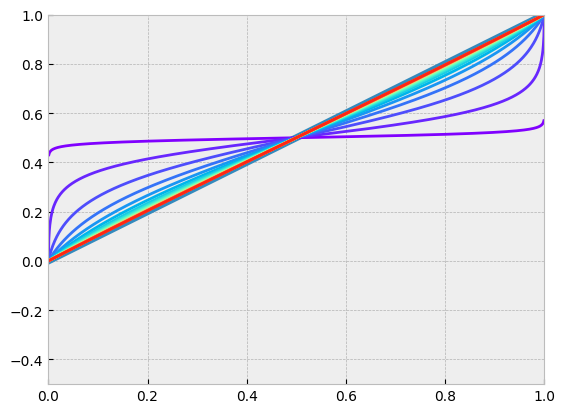

In [15]:
#def scaled_logit(p, s):
#    return s * -jnp.log((1 / p) - 1)

#def compute_x0(s):
#    return 1 / (jnp.exp(1 / (-2 * s)) + 1)

#def x_trans(x, x_0):
#    return x * (x_0 - (1 - x_0)) + (1 - x_0)

#def link_logit(p, s):
#    return scaled_logit(x_trans(p, compute_x0(s)), s) + 0.5

def link_linear(x, param):
  return param * x - (param / 2)

def link_logit(p,s):
  x0 = 1 / (jnp.exp(1 / (-2 * s)) + 1)
  xtrans = p * (x0 - (1 - x0)) + (1 - x0)
  return s * -jnp.log((1 / xtrans) - 1) + 0.5

def link_logis(x, param = 1):
    return 1 / (1 + jnp.exp(param * -(x - 0.5)))

def link_identity(x, param = 1):
    return x

# Generate a sequence of values
a = jnp.linspace(0.01, 1, 20)

# Plot the function fin(x,1)
x_values = jnp.linspace(0, 1, 1000)
y_values = link_logit(x_values, 20)
plt.plot(x_values, y_values, linewidth=5)
# Plot the function fin(x,s) for each value of s in a
for i, s in enumerate(a):
    y_values = link_logit(x_values, s)
    plt.plot(x_values, y_values, color=plt.cm.rainbow(i / len(a)))

plt.xlim([0, 1])
plt.ylim([-0.5, 1])
plt.show()

In [16]:
id = df_experiment.id.to_numpy()

In [38]:
# define the conditioned model for MCMC
vectorized_speaker = jax.vmap(speaker_recursive, in_axes=(None,0,None,None,None,None,None,None))

def model_gb_normal(states = None, data = None):
  alpha = numpyro.sample("alpha", dist.HalfNormal(5))
  bias = numpyro.sample("bias", dist.HalfNormal(5))
  color_semvalue = numpyro.sample("color_semvalue", dist.Uniform(0, 1))
  form_semvalue = color_semvalue
  wf = numpyro.sample("wf", dist.Uniform(0,1))
  k = numpyro.sample("k", dist.Uniform(0, 1))
  steepness = numpyro.sample("steepness", dist.HalfNormal(2))
  sigma = numpyro.sample("sigma", dist.Uniform(0,0.1))

  with numpyro.plate("data", len(states)):
    model_prob = jax.vmap(global_speaker, in_axes=(0,None,None,None,None,None,None))(states_train, alpha, bias, color_semvalue, form_semvalue, wf, k)
    slider_predict = jax.vmap(link_logit, in_axes = (0,None))(model_prob[:,0,0], steepness)
    slider_predict = jnp.clip(slider_predict, 1e-5, 1 - 1e-5)
    if data is not None:
      data = jnp.clip(data, 1e-5, 1 - 1e-5)
    numpyro.sample("obs", dist.TruncatedNormal(slider_predict, sigma, low = 1e-5, high = 1 - 1e-5,), obs=data)

def model_inc_utt_parallel_normal(states = None, data = None):
    gamma = numpyro.sample("gamma", dist.HalfNormal(5))
    color_semvalue = numpyro.sample("color_semvalue", dist.Uniform(0.5, 1))
    form_semvalue = color_semvalue
    k = numpyro.sample("k", dist.Uniform(0, 1))
    wf = numpyro.sample("wf", dist.Uniform(0,1))
    bias = numpyro.sample("bias", dist.HalfNormal(5))
    steepness = numpyro.sample("steepness", dist.HalfNormal(0.5))
    sigma = numpyro.sample("sigma", dist.Uniform(0,0.1))

    with numpyro.plate("data",len(states)):
      model_prob = vectorized_speaker(2, states_train, gamma, bias, color_semvalue, form_semvalue, wf, k)
      slider_predict = jax.vmap(link_logit, in_axes = (0,None))(model_prob[:,0,0], steepness)
      slider_predict = jnp.clip(slider_predict, 1e-5, 1 - 1e-5)
      if data is not None:
        data = jnp.clip(data, 1e-5, 1 - 1e-5)
      numpyro.sample("obs", dist.TruncatedNormal(slider_predict, sigma, low = 1e-5, high = 1 - 1e-5,), obs=data)



def model_inc_utt_parallel_beta(states = None, data = None):
    gamma = numpyro.sample("gamma", dist.HalfNormal(5))
    color_semvalue = numpyro.sample("color_semvalue", dist.Uniform(0, 1))
    k = numpyro.sample("k", dist.Uniform(0, 1))
    bias = numpyro.sample("bias", dist.HalfNormal(5))
    steepness = numpyro.sample("steepness", dist.HalfNormal(5))
    v = numpyro.sample("v", dist.Uniform(0,2))

    form_semvalue = color_semvalue
    wf = numpyro.sample("wf", dist.Uniform(0,1))

    with numpyro.plate("data",len(states)):
      model_prob = vectorized_speaker(2, states_train, gamma, bias, color_semvalue, form_semvalue, wf, k)
      slider_predict = jax.vmap(link_identity, in_axes = (0,None))(model_prob[:,0,0], steepness)
      slider_predict = jnp.clip(slider_predict, 1e-5, 1 - 1e-5)
      #slider_predict = jnp.clip(model_prob[:,0,0], 1e-5, 1 - 1e-5)
      alpha, beta = compute_alpha_beta_concentration(slider_predict, v)
      if data is not None:
        data = jnp.clip(data, 1e-5, 1 - 1e-5)
      numpyro.sample("obs", dist.Beta(alpha, beta), obs=data)


def model_inc_hierarchical_normal(id, states = None, data = None):
    gamma = numpyro.sample("gamma", dist.HalfNormal(5))
    color_semvalue = numpyro.sample("color_semvalue", dist.Uniform(0.5, 1))
    form_semvalue = color_semvalue
    k = numpyro.sample("k", dist.Uniform(0, 1))
    wf = numpyro.sample("wf", dist.Uniform(0,1))
    bias = numpyro.sample("bias", dist.HalfNormal(5))
    steepness = numpyro.sample("steepness", dist.HalfNormal(0.5))
    sigma = numpyro.sample("sigma", dist.Uniform(0,0.1))

    n_ids = len(np.unique("id"))
    mu = numpyro.sample("mu", dist.Normal(0,1))
    s = numpyro.sample("s", dist.HalfNormal(0.25))
    with numpyro.plate("plate_i", n_ids):
        intercept = numpyro.sample("intercept", dist.Normal(mu, s))

    with numpyro.plate("data",len(states)):
      model_prob = vectorized_speaker(2, states_train, gamma, bias, color_semvalue, form_semvalue, wf, k)
      slider_predict = jax.vmap(link_logit, in_axes = (0,None))(model_prob[:,0,0], steepness)
      slider_predict = intercept[id] + slider_predict
      slider_predict = jnp.clip(slider_predict, 1e-5, 1 - 1e-5)
      if data is not None:
        data = jnp.clip(data, 1e-5, 1 - 1e-5)
      numpyro.sample("obs", dist.TruncatedNormal(slider_predict, sigma, low = 1e-5, high = 1 - 1e-5,), obs=data)


In [39]:
# define the MCMC kernel and the number of samples
rng_key = random.PRNGKey(11)
rng_key, rng_key_ = random.split(rng_key)

#kernel = NUTS(model_inc_utt_parallel_beta, dense_mass=True, max_tree_depth=15, target_accept_prob=0.95)
#mcmc_inc = MCMC(kernel, num_warmup=2500,num_samples=7500,num_chains=4)
#mcmc_inc.run(rng_key_, states_train, empirical_train)

# print the summary of the posterior distribution
#mcmc_inc.print_summary()

# Get the MCMC samples and convert to a DataFrame
#posterior_inc = mcmc_inc.get_samples()
#df_inc = pd.DataFrame(posterior_inc)

# Save the DataFrame to a CSV file
#df_inc.to_csv('/content/drive/MyDrive/posterior_inc_utt_slider.csv', index=False)

In [40]:
import csv

result_dict = {}
filename = '/content/drive/MyDrive/posterior_samples/02_inc_normal_logit_sample.csv'


def read_csv_to_dict(filename):
    data_dict = {}
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)
        for row in reader:
            for key, value in zip(header, row):
                if key in data_dict:
                    data_dict[key].append(float(value))
                else:
                    data_dict[key] = [float(value)]

    # Convert values to JAX arrays
    for key, values in data_dict.items():
        data_dict[key] = jnp.array(values)

    return data_dict

csv_data = read_csv_to_dict(filename)
df_inc = pd.DataFrame(csv_data)
# Access the data dictionary
for key, values in csv_data.items():
    print(key, values[:10])

bias [0.30157992 0.29164416 0.28472203 0.32609987 0.3180708  0.3120944
 0.3058657  0.30130318 0.29318014 0.2968551 ]
color_semvalue [0.9405116  0.9392054  0.9394058  0.93961895 0.94025266 0.9391159
 0.9395866  0.9395534  0.93966997 0.93977845]
gamma [3.109768  3.193699  3.3192475 3.1353185 3.0755193 3.1484838 3.0995212
 3.1834638 3.2033472 3.221435 ]
k [0.4823778  0.48669145 0.48498416 0.49694556 0.5240016  0.4251347
 0.46034396 0.45381016 0.46135947 0.44897062]
sigma [0.09999894 0.09999937 0.09999936 0.09999359 0.09999919 0.09999938
 0.09999211 0.09999713 0.0999992  0.09999881]
steepness [0.7255232  0.65006196 0.4073815  0.5674959  0.6334251  1.514776
 1.047703   0.71740377 0.64156437 0.5684933 ]
wf [0.92386484 0.932536   0.9436391  0.9395384  0.9337469  0.9427488
 0.92982286 0.9329793  0.9329566  0.92991066]


In [41]:
# create a MAP dict of posterior samples
'''
from statistics import mode

map_dict = {}
for key, values in csv_data.items():
    # Convert JAX array back to list to calculate mode
    values_list = jnp.array(values).tolist()
    map_dict[key] = jnp.array(mode(values_list))

# Print the new dictionary to check it
for key, value in map_dict.items():
    print(key, value)


def MAP_predictive(states):
    form_semvalue = map_dict['color_semvalue']
    with numpyro.plate("data",len(states)):
        model_prob = vectorized_speaker(2, states, map_dict['gamma'], map_dict['bias'], map_dict['color_semvalue'], form_semvalue, map_dict['wf'], map_dict['k'])
        slider_predict = jax.vmap(link_function, in_axes = (0,None))(model_prob[:,0,0], map_dict['steepness'])
        slider_predict = jnp.clip(slider_predict, 1e-5, 1 - 1e-5)
        alpha, beta = compute_alpha_beta_concentration(slider_predict, map_dict['v'])

    return numpyro.sample("obs", dist.Beta(alpha, beta))

num_samples = 10  # Specify the number of samples you want to draw
num_states = len(states_train)

# Initialize a 2D array to hold the predictions
# The first dimension will hold the predictions for each state
# The second dimension will hold the results of each iteration
MAP_preds = jnp.zeros((num_states, num_samples))

with handlers.seed(rng_seed=0):
    for i in range(num_samples):
        MAP_pred = MAP_predictive(states_train)
        MAP_preds.at[:, i].set(MAP_pred)


print(jnp.shape(MAP_preds))
'''

'\nfrom statistics import mode\n\nmap_dict = {}\nfor key, values in csv_data.items():\n    # Convert JAX array back to list to calculate mode\n    values_list = jnp.array(values).tolist()\n    map_dict[key] = jnp.array(mode(values_list))\n\n# Print the new dictionary to check it\nfor key, value in map_dict.items():\n    print(key, value)\n\n\ndef MAP_predictive(states):\n    form_semvalue = map_dict[\'color_semvalue\']\n    with numpyro.plate("data",len(states)):\n        model_prob = vectorized_speaker(2, states, map_dict[\'gamma\'], map_dict[\'bias\'], map_dict[\'color_semvalue\'], form_semvalue, map_dict[\'wf\'], map_dict[\'k\'])\n        slider_predict = jax.vmap(link_function, in_axes = (0,None))(model_prob[:,0,0], map_dict[\'steepness\'])\n        slider_predict = jnp.clip(slider_predict, 1e-5, 1 - 1e-5)\n        alpha, beta = compute_alpha_beta_concentration(slider_predict, map_dict[\'v\'])\n\n    return numpyro.sample("obs", dist.Beta(alpha, beta))\n\nnum_samples = 10  # Specif

In [42]:
from numpyro.infer import Predictive

rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model_inc_utt_parallel_normal, csv_data)
predictions = predictive(rng_key_, states = states_train)["obs"]

In [43]:
print(jnp.shape(predictions))
mean = jnp.mean(predictions, axis=1)
print(mean[:10])

(30000, 3125)
[0.70432293 0.6992475  0.7019192  0.702105   0.7032696  0.6991944
 0.70018226 0.7009653  0.7010324  0.70284045]


In [44]:
df_pred = df_experiment.filter(["id","sharpness","relevant_property","states", "prefer_first_1st"])
df_pred["mean_predictions"] = jnp.mean(predictions, axis=0) - 0.5
#df_pred["MAP_predictions"] = MAP_pred
df_pred["prefer_first_1st"] = df_pred["prefer_first_1st"] - 0.5
df_pred["std_predictions"] = jnp.std(predictions, axis=0)
df_pred

print(df_pred.prefer_first_1st.describe())
print(df_pred.mean_predictions.describe())
#print(df_pred.MAP_predictions.describe())

count    3125.000000
mean        0.200768
std         0.381771
min        -0.500000
25%         0.000000
50%         0.410000
75%         0.500000
max         0.500000
Name: prefer_first_1st, dtype: float64
count    3125.000000
mean        0.200809
std         0.113840
min         0.041324
25%         0.059490
50%         0.225980
75%         0.315764
max         0.346745
Name: mean_predictions, dtype: float64


In [45]:
from plotnine import *
from siuba import *

In [46]:
#aggregated_df_pred = df_pred  >> group_by("sharpness", "relevant_property") >> summarize(mean_empirical = _.prefer_first_1st.mean(), std_empirical = _.prefer_first_1st.std(), mean_pred = _.mean_predictions.mean(), std_pred = _.mean_predictions.std(), MAP_pred = _.MAP_predictions.mean(), std_MAP_pred = _.MAP_predictions.std())
aggregated_df_pred = df_pred  >> group_by("sharpness", "relevant_property") >> summarize(mean_empirical = _.prefer_first_1st.mean(), std_empirical = _.prefer_first_1st.std(), mean_pred = _.mean_predictions.mean(), std_pred = _.mean_predictions.std())
print(aggregated_df_pred)

from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_squared_error
# R2 score requires true values as first argument
print(f"R2 score between true and predicted data is: {r2_score(df_pred.prefer_first_1st,df_pred.mean_predictions)}")
print(f"R2 score between aggregated true and predicted data is: {r2_score(aggregated_df_pred.mean_empirical,aggregated_df_pred.mean_pred)}")
print(f"Correlation between true and predicted data is: {pearsonr(df_pred.prefer_first_1st,df_pred.mean_predictions)}")
print(f"Correlation between aggregated true and predicted data is: {pearsonr(aggregated_df_pred.mean_empirical,aggregated_df_pred.mean_pred)}")
print(f"MSE between true and predicted data is: {mean_squared_error(df_pred.prefer_first_1st,df_pred.mean_predictions)}")

  sharpness relevant_property  mean_empirical  std_empirical  mean_pred  \
0   blurred              both        0.252476       0.329657   0.246900   
1   blurred             first        0.298959       0.299281   0.314331   
2   blurred            second        0.057861       0.424966   0.054859   
3     sharp              both        0.208442       0.379120   0.210510   
4     sharp             first        0.350962       0.269893   0.336207   
5     sharp            second        0.047803       0.443573   0.055096   

   std_pred  
0  0.022126  
1  0.020395  
2  0.006146  
3  0.023081  
4  0.005801  
5  0.005749  
R2 score between true and predicted data is: 0.08928197928024306
R2 score between aggregated true and predicted data is: 0.9929940870317278
Correlation between true and predicted data is: PearsonRResult(statistic=0.2988015271836674, pvalue=1.8011889428774877e-65)
Correlation between aggregated true and predicted data is: PearsonRResult(statistic=0.9965977153140254, pvalue=1

In [47]:
id = df_experiment.id.to_numpy()
df_grouped = df_pred.groupby(['id', 'sharpness', 'relevant_property'])['mean_predictions'].mean().reset_index()


#aggregated_df_pred_pps = df_pred  >> group_by("id","sharpness", "relevant_property") >> summarize(mean_empirical = _.prefer_first_1st.mean(), std_empirical = _.prefer_first_1st.std(), mean_pred = _.mean_predictions.mean(), std_pred = _.mean_predictions.std())
#print(aggregated_df_pred_pps)


In [48]:
import statsmodels.formula.api as smf

md_1 = smf.mixedlm("mean_predictions ~ sharpness * relevant_property", df_grouped, groups=df_grouped["id"])
md_2 = smf.mixedlm("mean_predictions ~ sharpness + relevant_property", df_grouped, groups=df_grouped["id"])
mdf_1 = md_1.fit()
mdf_2 = md_2.fit()

print(mdf_1.summary())
print(mdf_2.summary())

log_likelihood_model1 = mdf_1.llf
log_likelihood_model2 = mdf_2.llf

import scipy.stats as stats

# Assume log_likelihood_model1 and log_likelihood_model2 are the log-likelihoods for your two models
# and df_model1 and df_model2 are the degrees of freedom (number of parameters) for the two models

test_statistic = 2 * (log_likelihood_model1 - log_likelihood_model2)
df = 2

p_value = stats.chi2.sf(test_statistic, df) # sf is the survival function, which is 1 - cdf

print("Test statistic: ", test_statistic)
print("Degrees of freedom: ", df)
print("p-value: ", p_value)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs


                           Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          mean_predictions
No. Observations:            357              Method:                      REML            
No. Groups:                  119              Scale:                       0.0000          
Min. group size:             3                Log-Likelihood:              1474.7308       
Max. group size:             3                Converged:                   Yes             
Mean group size:             3.0                                                           
-------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------
Intercept                                       0.247    0.000  539.667 0.000  0.246  0.248
sharpness[T.sha

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.


In [49]:
from numpyro.infer import log_likelihood
log_lk_vals = jnp.array(list(log_likelihood(model_inc_utt_parallel_normal, csv_data, states_train, empirical_train).values()))

In [50]:
n = list(csv_data.values())[0].shape[0]
lpd = logsumexp(log_lk_vals, 0) - jnp.log(n).sum()
print(jnp.shape(lpd))

def log_likelihood(rng_key, params, model, *args, **kwargs):
    model = handlers.condition(model, params)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    obs_node = model_trace["obs"]
    return obs_node["fn"].log_prob(obs_node["value"])


def log_pred_density(rng_key, params, model, *args, **kwargs):
    n = list(params.values())[0].shape[0]
    log_lk_fn = vmap(
        lambda rng_key, params: log_likelihood(rng_key, params, model, *args, **kwargs)
    )
    log_lk_vals = log_lk_fn(random.split(rng_key, n), params)
    return (logsumexp(log_lk_vals, 0) - jnp.log(n)).sum()

print(
    "Log posterior predictive density: {}".format(jnp.mean(lpd)))

(30000, 3125)
Log posterior predictive density: -15.543495178222656


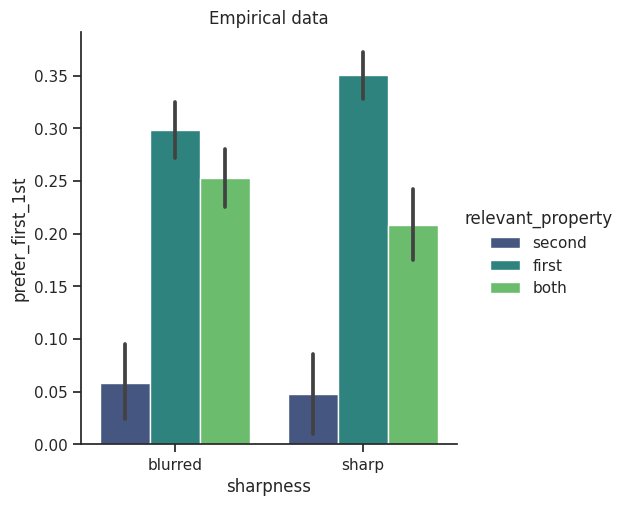

In [51]:
sns.catplot(x='sharpness', y='prefer_first_1st', hue='relevant_property', data=df_pred, kind='bar',
            palette='viridis').set(title='Empirical data')

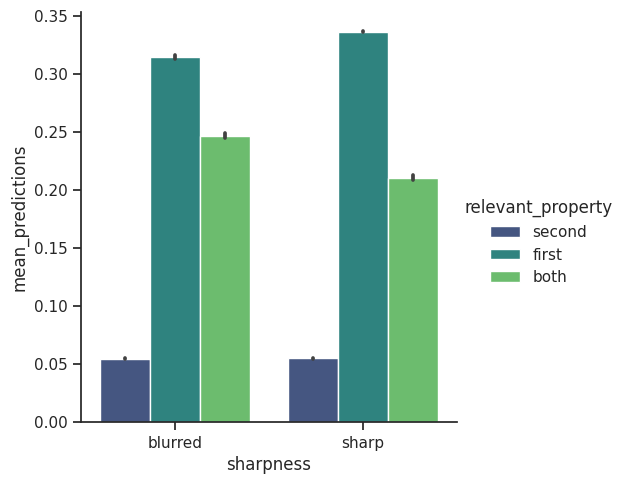

In [52]:
sns.catplot(x='sharpness', y='mean_predictions', hue='relevant_property', data=df_pred, kind='bar',
            palette='viridis')

In [53]:
#sns.catplot(x='sharpness', y='MAP_predictions', hue='relevant_property', data=df_pred, kind='bar',
#            palette='viridis').set(title='MAP Predictive data')

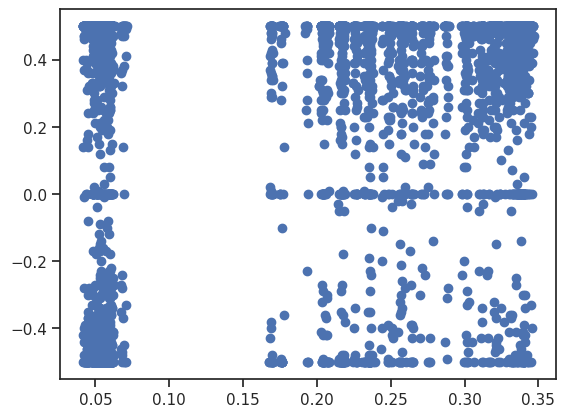

In [54]:
plt.scatter(df_pred.mean_predictions,df_pred.prefer_first_1st)
plt.show()

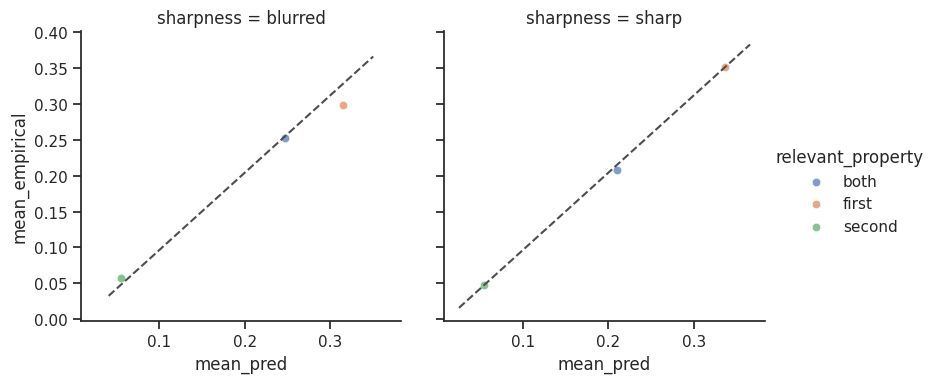

In [55]:
sns.set(style="ticks")

g = sns.FacetGrid(aggregated_df_pred, col="sharpness", hue="relevant_property", height=4)
g.map(sns.scatterplot,"mean_pred", "mean_empirical", alpha=0.7)

# Add a 45 degree line to each facet
for ax in g.axes.flatten():
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

g.add_legend()

plt.show()


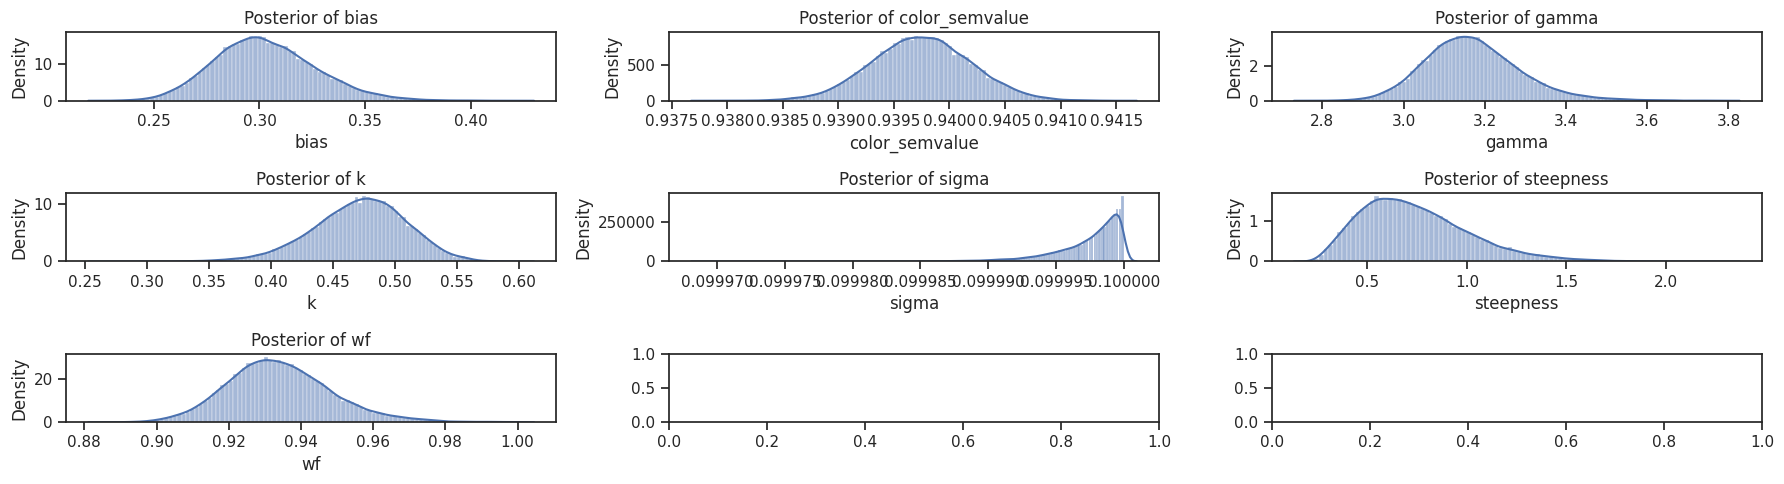

In [56]:
def plot_parameter(df, type = "Posterior"):
    # create subplots based on how many parameters (ncols) we have
    numbers = len(df.columns)
    ncols = 3
    nrows = int(np.ceil(numbers/ncols))
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=(18, 5))
    # plot each parameter
    for i, col in enumerate(df.columns):
        sns.histplot(df[col], kde=True, kde_kws = dict(cut = 3), stat="density", ax=axes[i//ncols, i%ncols])
        axes[i//ncols, i%ncols].set_title(f"{type} of {col}")
    plt.tight_layout()
    plt.show()

plot_parameter(df_inc)